# A MultiLayer fitting model

One of the main tools in `EasyReflectometry` is the [item library](./item.html). 
This allows the user to define their model, using specific parameters for their system of interest (if it is included in the item library). 
These items will impose necessary constraints and computational efficiencies based on the item that is used. 

In this tutorial, we will look at one of these items, that of a [`RepeatingMultiLayer`](https://easyscience.github.io/EasyReflectometryLib/item.html#EasyReflectometry.sample.item.RepeatingMultiLayer). 
This tutorial is based on an example from the [BornAgain](https://www.bornagainproject.org) documentation looking at [specular reflectivity analysis](https://www.bornagainproject.org/m/py/fitting/extended/fit-specular-data/). 
Before performing analysis, we should import the packages that we need.

In [1]:
import numpy as np
import scipp as sc
import EasyReflectometry
import refl1d
from EasyReflectometry.data import load
from EasyReflectometry.sample import Material, Layer, Structure
from EasyReflectometry.sample.item import RepeatingMultiLayer
from EasyReflectometry.experiment.model import Model
from EasyReflectometry.interface import InterfaceFactory as Calculator
from EasyReflectometry.fitting import Fitter
from EasyReflectometry.plot import plot

As mentioned in the [previous tutorial](./simple_fitting.html), we share the version of the software packages we will use. 

In [2]:
print(f'numpy: {np.__version__}')
print(f'scipp: {sc.__version__}')
print(f'EasyReflectometry: {EasyReflectometry.__version__}')
print(f'Refl1D: {refl1d.__version__}')

numpy: 1.21.5
scipp: 0.11.1
EasyReflectometry: 0.0.1
Refl1D: 0.8.15


In [3]:
data = load('_static/repeating_layers.ort')

In [4]:
data

<scipp.Dataset>
Dimensions: Sizes[Qz0:1998, ]
Coordinates:
  Qz0                       float64           [1/Å]  (Qz0)  [0.000712093, 0.00106814, ..., 0.71048, 0.710835]  [0, 0, ..., 0, 0]
Data:
  data_set0                 float64  [dimensionless]  (Qz0)  [1, 1, ..., 1.53327e-09, 4.01668e-09]  [0.0025, 0.0025, ..., 5.87727e-21, 4.03343e-20]

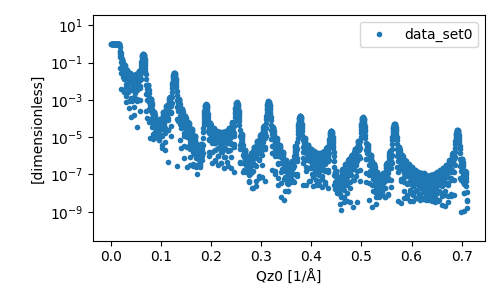

In [5]:
plot(data)

In [6]:
si = Material.from_pars(2.07, 0, 'Si')
ni = Material.from_pars(9.4245, 0, 'Ni')
ti = Material.from_pars(-1.9493, 0, 'Ti')
air = Material.from_pars(0, 0, 'Air')

In [15]:
si_layer = Layer.from_pars(si, 0, 0, 'Si Layer')
ni_layer = Layer.from_pars(ni, 50, 0, 'Ni Layer')
ti_layer = Layer.from_pars(ti, 40, 0, 'Ti Layer')
subphase = Layer.from_pars(air, 0, 0, 'Subphase')

In [16]:
niti_multilayer = RepeatingMultiLayer.from_pars([ni_layer, ti_layer], repetitions=10, name='NiTi Multilayer')

In [17]:
structure = Structure.from_pars(si_layer, niti_multilayer, subphase, name='Film Structure')

In [18]:
structure

<Film Structure: A series of 3 items>
  - <Si Layer: (<Si Layer: A series of 1 layers>
  - <Si Layer: (material: <Si: (sld: 2.070e-6 1/Å², isld: 0.000e-6 1/Å²)>, thickness: 0.000 Å, roughness: 0.000 Å)>)>
  - <NiTi Multilayer: (10.0 repetitions of [<Ni Layer: (material: <Ni: (sld: 9.425e-6 1/Å², isld: 0.000e-6 1/Å²)>, thickness: 50.000 Å, roughness: 0.000 Å)>, <Ti Layer: (material: <Ti: (sld: -1.949e-6 1/Å², isld: 0.000e-6 1/Å²)>, thickness: 40.000 Å, roughness: 0.000 Å)>])>
  - <Subphase: (<Subphase: A series of 1 layers>
  - <Subphase: (material: <Air: (sld: 0.000e-6 1/Å², isld: 0.000e-6 1/Å²)>, thickness: 0.000 Å, roughness: 0.000 Å)>)>

In [19]:
model = Model.from_pars(structure, 1, 1e-6, 0.02, 'Film Model')

In [20]:
model.structure

<Film Structure: A series of 3 items>
  - <Si Layer: (<Si Layer: A series of 1 layers>
  - <Si Layer: (material: <Si: (sld: 2.070e-6 1/Å², isld: 0.000e-6 1/Å²)>, thickness: 0.000 Å, roughness: 0.000 Å)>)>
  - <NiTi Multilayer: (10.0 repetitions of [<Ni Layer: (material: <Ni: (sld: 9.425e-6 1/Å², isld: 0.000e-6 1/Å²)>, thickness: 50.000 Å, roughness: 0.000 Å)>, <Ti Layer: (material: <Ti: (sld: -1.949e-6 1/Å², isld: 0.000e-6 1/Å²)>, thickness: 40.000 Å, roughness: 0.000 Å)>])>
  - <Subphase: (<Subphase: A series of 1 layers>
  - <Subphase: (material: <Air: (sld: 0.000e-6 1/Å², isld: 0.000e-6 1/Å²)>, thickness: 0.000 Å, roughness: 0.000 Å)>)>

In [21]:
ti_layer.thickness.min = 10
ti_layer.thickness.max = 60
ti_layer.thickness.fixed = False

In [22]:
calculator = Calculator()
model.interface = calculator

KeyError: 300109484847121224867957332317693980154